In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import matplotlib.pyplot as plt
import time as time
import seaborn as sns
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from EEG import EEG
from init_TF import init_TF
from behavior import load_posBin

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
eeg = EEG()
eeg.load('../EEG/1_EEGfilt.mat')
eeg.drop_artifacts()
eeg.drop_electrodes()

nChans, nBins, nElectrodes = 8, 8, 20

basisSet = init_TF(nChans, nBins)

posBin = load_posBin(f'..\\data\\1_Behavior.mat')
posBin = posBin[eeg.art.artInd.transpose()==0]

assert(eeg.eeg.shape == (float(eeg.nTrials - sum(eeg.art.artInd)), nElectrodes, (float(eeg.postTime-eeg.preTime)/4)+1))

[Text(0.5, 1.0, 'Position of bin = [6]')]

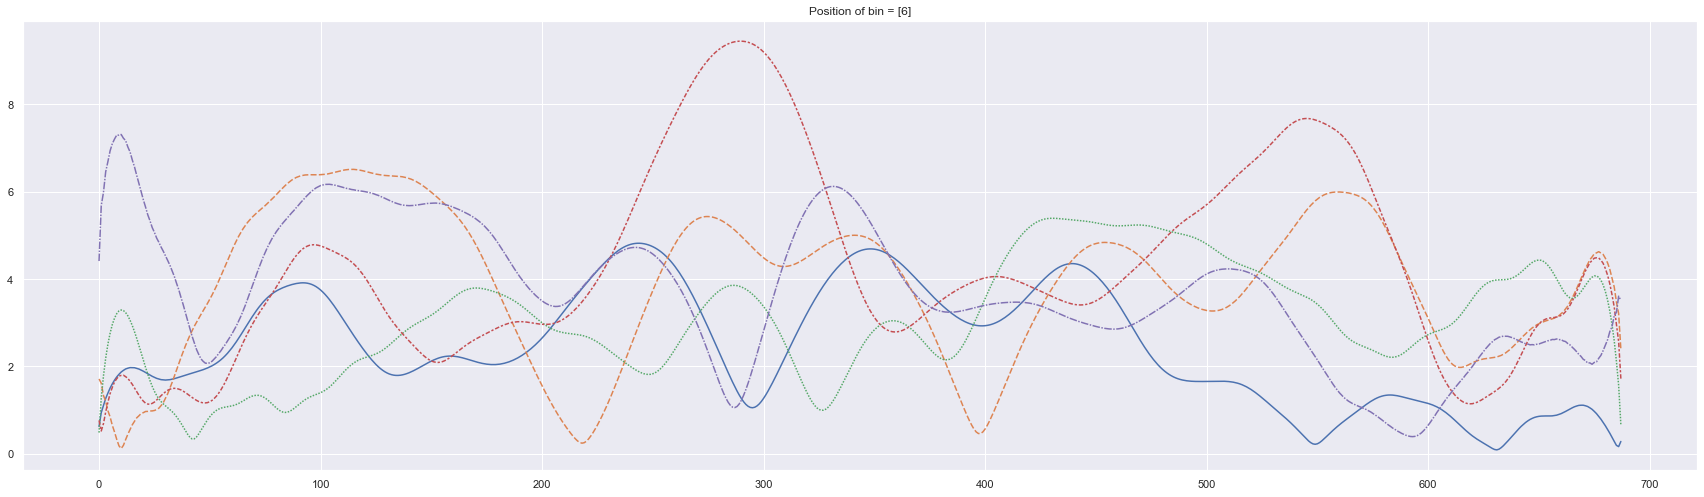

In [17]:
trial_number = 3
sns.set(rc={'figure.figsize':(30,8.27)})
sns.lineplot(data=eeg.eeg_total()[(posBin==5).transpose()[0], 10, :].transpose()[:, :5], legend=False).set(title=f'Position of bin = {posBin[trial_number-1]}')

MAKING BLOCKS

In [12]:
toi_start = -500
toi_end = 1249
nBlocks = 3
nTrials = eeg.nTrials - np.sum(eeg.art.artInd)

blocks = np.empty((np.shape(posBin)))

shuffBlocks = np.empty((np.shape(posBin)))

# count number of trials within each position bin
binCnt = np.empty((nBins))
for bin in range(nBins):
    binCnt[bin] = np.sum(1 * np.equal(posBin, bin))

# Data from binCnt: binCnt[0, x] where 0 <= x <= 7

minCnt = min(binCnt)  # No. of trials for position bin with fewest trials

# max No. of trials such that the No. of trials for each bin
# can be equated within each block
nPerBin = int(np.floor(minCnt / nBlocks))

shuffInd = np.array([np.random.permutation(nTrials)]).transpose()  # create shuffle index
shuffBin = posBin[shuffInd.squeeze(), 0]  # shuffle trial order
shuffeeg = eeg.eeg_total()[shuffInd.squeeze(), :, (toi_start+1000)//4:(toi_end+1000)//4]

blocks = []

for block in range(nBlocks):
    blocks.append([])
    for i in range(nBins):
        
        binSpecific = shuffeeg[(posBin==i).squeeze(), :, :]
        average = np.average(binSpecific[0:nPerBin], axis=0)
        blocks[-1].append(average)

blocks = np.array(blocks)


We make a models for different time points \
Input to every model -  C1: (8, 1) - Estimated channel responses \
Weights of this model - W : (20, 8) 

B1 = W*C1 

Output of every model -  B1_pred: (20, 1) - Predicted Electrode values \
We have (training bins * 8) = 16 training examples for every model \
We will try to overfit these models


B1 -> C1_pred <-> C1_actual \
B1 -> bin_pred <-> bin_actual

In [2]:
def Model(t):
    input = keras.Input(shape=(8,))
    output = layers.Dense(20, activation='linear', use_bias=False)(input)

    model = keras.Model(inputs=input, outputs = output, name='t')
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.RMSprop())
    

    return model


In [13]:
def train_at_time_t(t, blocks=blocks):
    y_train = blocks[:2, :, :, (t+1000)//4].transpose()
    x_train, y_train = np.concatenate((basisSet, basisSet), 0), y_train.reshape((y_train.shape[0], -1)).transpose()
    y_test = blocks[-1, :, :, (t+1000)//4].transpose()
    x_test, y_test = basisSet, y_test.reshape((y_test.shape[0], -1)).transpose()
    model = Model(t)
    print(f"Training model at time {t}")
    history = model.fit(x_train, y_train, batch_size=1, epochs=500, verbose=0)
    print(f"Trained model at time {t}. Final loss = {history.history['loss'][-1]}. Elapsed time: {time.time() - start_time}")
    return model, x_test, y_test, history

Training model at time 600
Trained model at time 600. Final loss = 0.04020874947309494. Elapsed time: 16.107195138931274
Training model at time 600
Trained model at time 600. Final loss = 0.039168909192085266. Elapsed time: 18.665011882781982
Training model at time 600
Trained model at time 600. Final loss = 0.04010915383696556. Elapsed time: 17.809281587600708
Training model at time 600
Trained model at time 600. Final loss = 0.038910187780857086. Elapsed time: 16.747252941131592
Training model at time 600
Trained model at time 600. Final loss = 0.03909602388739586. Elapsed time: 17.259106874465942
Training model at time 600
Trained model at time 600. Final loss = 0.03950236365199089. Elapsed time: 16.02247643470764
Training model at time 600
Trained model at time 600. Final loss = 0.03935524821281433. Elapsed time: 17.002901315689087
Training model at time 600
Trained model at time 600. Final loss = 0.03994600847363472. Elapsed time: 16.39626121520996
Training model at time 600
Train

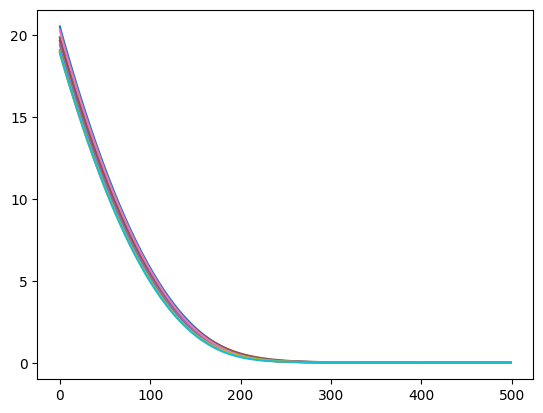

In [18]:
start_time = time.time()
for i in range(10):
    _, _ , _ , history = train_at_time_t(600)
    plt.plot(history.history['loss'])
plt.show()

In [8]:
model, x_test, y_test, _ = train_at_time_t(500)

Training model at time 500
Trained model at time 500. Final loss = 0.12728458642959595. Elapsed time: 9.551804780960083


In [9]:
W = np.array(model.weights[0])
W.shape

(8, 20)

In [10]:
x_test.shape

(8, 8)

In [11]:
y_test.shape

(8, 20)

B2 = W*C2

In [12]:
C2 = np.linalg.lstsq(W.conj().transpose(), y_test.conj().transpose(), rcond=None)[0].conj().transpose()

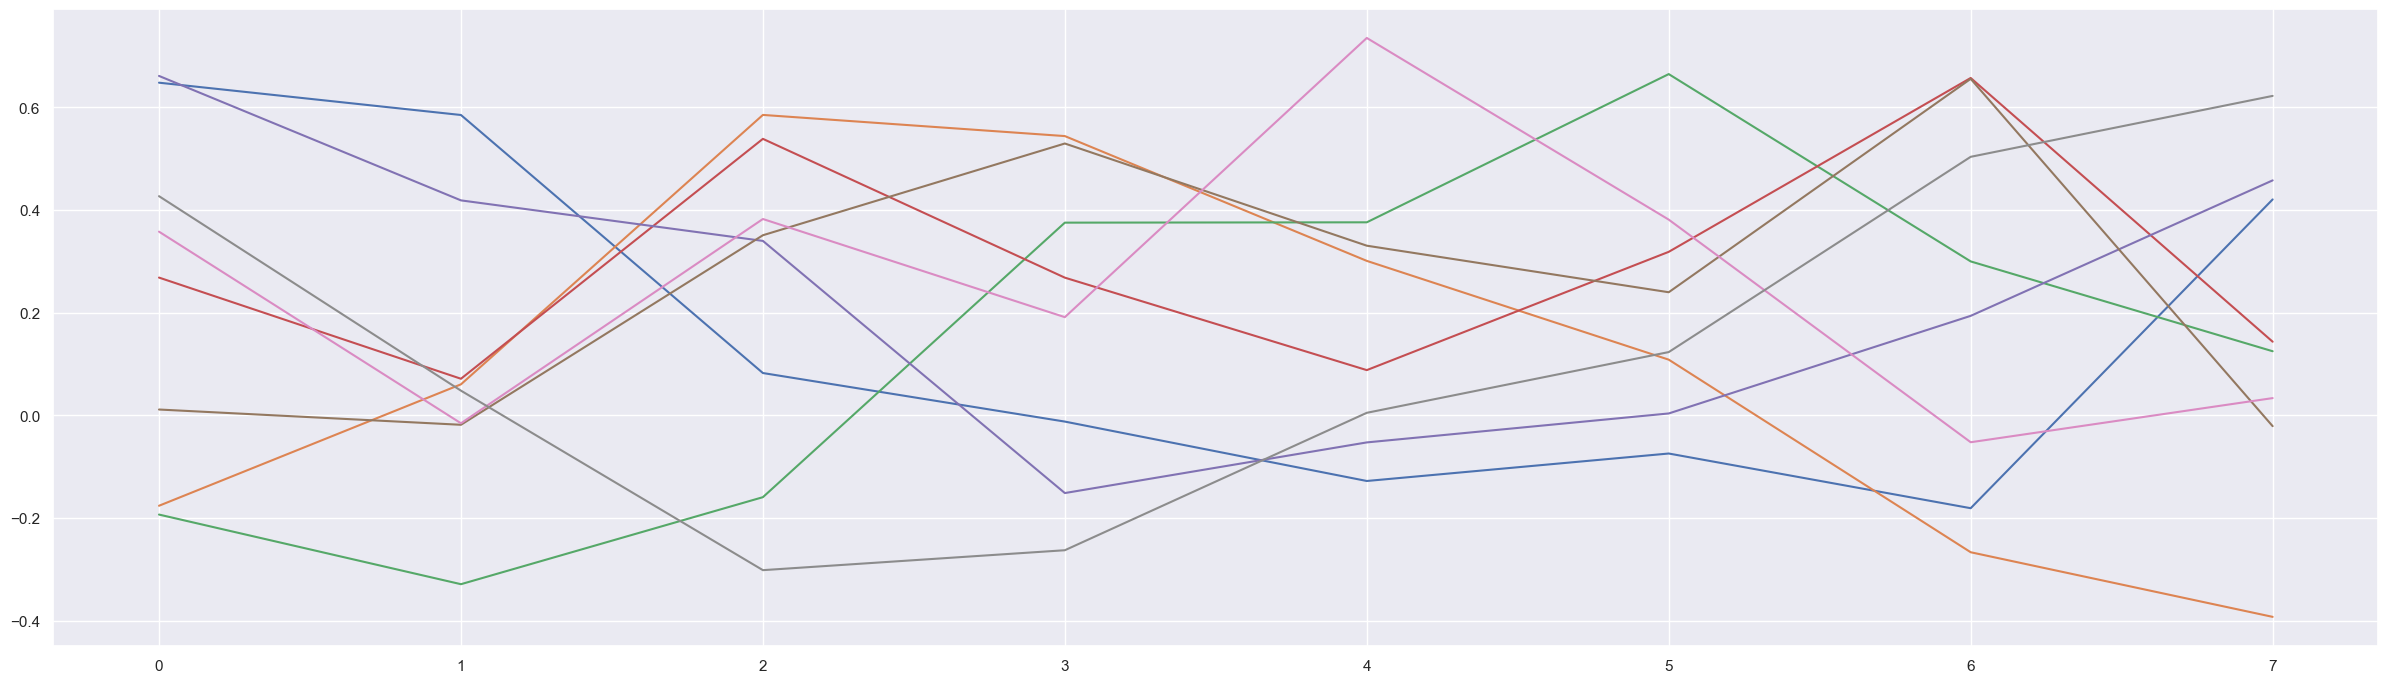

In [13]:
for i in range(len(C2)):
    plt.plot(C2[i]/np.linalg.norm(C2[i]))
plt.show()

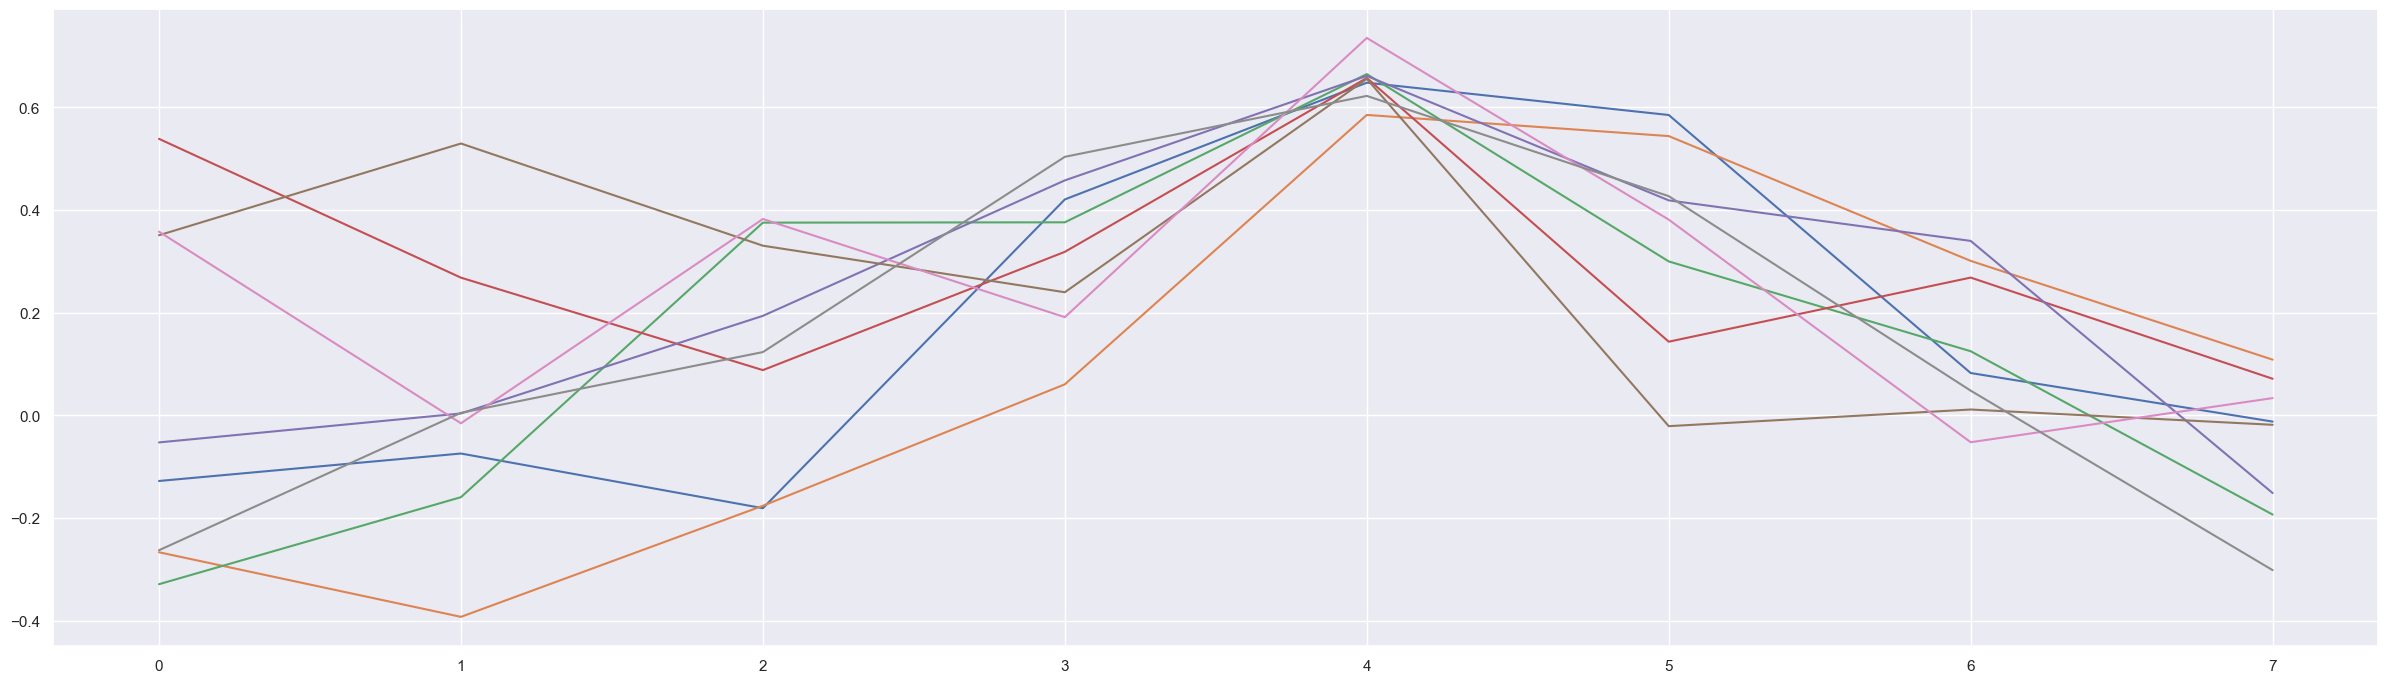

In [14]:
for i in range(len(C2)):
    plt.plot(np.roll(C2[i], 4-C2[i].argmax())/np.linalg.norm(C2[i]))

plt.show()

In [15]:
n2shift = int(np.ceil(C2.shape[1] / 2))
for ii in range(1, C2.shape[0] + 1):
    shiftInd = np.argmin(abs(posBins - tstl[ii - 1])[0]) + 1
    C2[ii - 1, :] = np.roll(C2[ii - 1, :], shiftInd - n2shift - 1)

for i in range(len(C2)):
    plt.plot(C2[i])

plt.show()

NameError: name 'posBins' is not defined

C1[BASISSET]->W->B1  <--> B1_actual -- Perceptron (8, 20)
B2->W->C2 -- Least squares

B->W->bins(locations)

# Making Heatmaps from Model Weights

In [3]:
import matplotlib.pyplot as plt

In [4]:
t = 152
model = Model(t)

In [5]:
tf.get_logger().setLevel('INFO')

In [6]:
weights = np.zeros((150, 8, 20))
for t in range(100, 700, 4):
    model = Model(t)
    model.load_weights(f'./Trained Models/{t}')
    weights[int((t-100)/4), :, :] = model.weights[0]

In [7]:
def calculate_C2_at_time_t(t):
    W = weights[int((t-100)/4), :, :]
    y_test = blocks[-1, :, :, (t+1000)//4].transpose()
    y_test = y_test.reshape((y_test.shape[0], -1)).transpose()
    C2 = np.linalg.lstsq(W.conj().transpose(), y_test.conj().transpose(), rcond=None)[0].conj().transpose()
    for i in range(len(C2)):
        C2[i] = (np.roll(C2[i], 1)/np.linalg.norm(C2[i]))
    return C2

In [14]:
activations = np.zeros((150, 8, 8))
for t in range(100, 700, 4):
    activations[int((t-100)/4), :, :] = calculate_C2_at_time_t(t)

activations : (time, 8 chans, 8 bins)

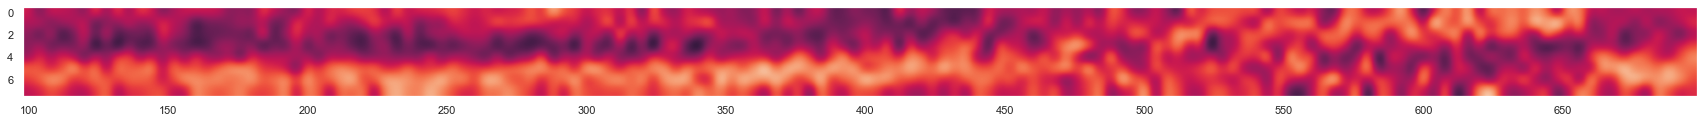

In [18]:
fig, ax = plt.subplots()
plt.grid(False)
plt.xticks(ticks=np.arange(0, 150, 12.5), labels=np.arange(100, 700, 50))
im = ax.imshow(np.mean(activations, axis=1).transpose(), interpolation="quadric")

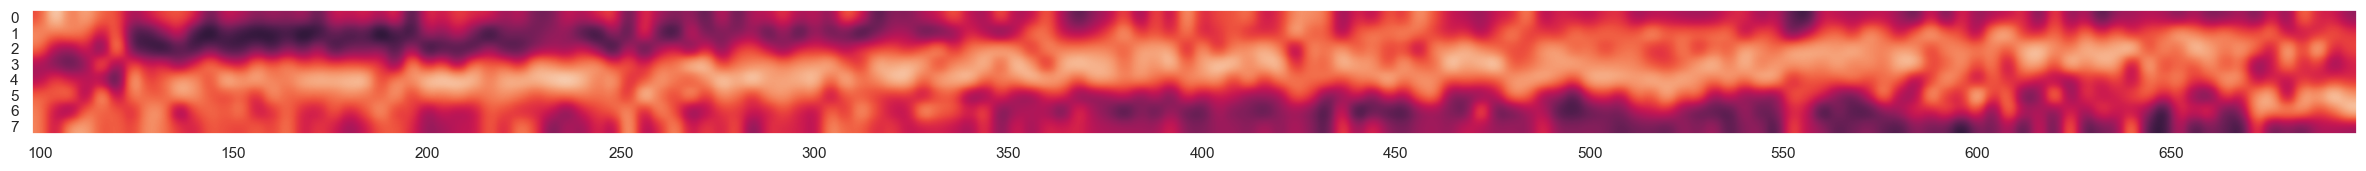

In [55]:
fig, ax = plt.subplots()
ax.grid(False)
plt.xticks(ticks=np.arange(0, 150, 12.5), labels=np.arange(100, 700, 50))
plt.yticks([0,1,2,3,4,5,6,7])
im = ax.imshow(activations[:, 7, :].transpose(),interpolation="quadric")

1. check this for all participants
2. improve training style

In [26]:
np.arange(100, 700, 100)

array([100, 200, 300, 400, 500, 600])

TypeError: Locator.tick_values() missing 2 required positional arguments: 'vmin' and 'vmax'